In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import dask
from scipy.stats import theilslopes
import pymannkendall as mk
import matplotlib.pyplot as plt
import matplotlib.colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import SymLogNorm
import cmocean
import os

exp = 'historical'
MODELS = [
    "ACCESS-ESM1-5", "CanESM5", "CMCC-CM2-SR5", 
    "HadGEM3-GC31-LL", "MIROC6", "MPI-ESM1-2-LR",
    "NorESM2-LM"
]

ERA5_mask = xr.open_dataset('~/ERA5_lsm_NH.nc')
ERA5_mask = ERA5_mask.rename({
    "longitude": "lon",
    "latitude": "lat",
    "time": "valid_time"
})

ERA5_mask = ERA5_mask.sel(lon=slice(-25,45), lat=slice(72, 36))
if ERA5_mask['lat'][0] > ERA5_mask['lat'][-1]:
    ERA5_mask = ERA5_mask.sortby('lat')
land_mask_binary = xr.where(ERA5_mask > 0, 1, 0) 
lsm = land_mask_binary['lsm']

In [2]:
ERA5_trends = xr.open_dataset('data/ERA5_historical_trends.nc')
if ERA5_trends['lat'][0] > ERA5_trends['lat'][-1]:
    ERA5_trends = ERA5_trends.sortby('lat')
ERA5_trends = ERA5_trends.where(lsm == 1)

In [3]:
# Get the ERA5 time series
def load_era5(lat1, lat2):
    ERA5 = xr.open_dataset('/home/users/tildah/Internship/ERA5/ERA5_HWF_with2025.nc')
    mask = xr.open_dataset('~/ERA5_lsm_NH.nc').rename({"longitude": "lon", "latitude": "lat"})
    mask = mask.sel(lon=slice(-25, 45), lat=slice(lat2, lat1))
    lsm = xr.where(mask > 0, 1, 0).interp_like(ERA5)['lsm']
    land = ERA5.where(lsm == 1)
    weights = np.cos(np.deg2rad(land.lat))
    return land['days'].weighted(weights).mean(dim=("lat", "lon"))

lat1 = 36
lat2 = 72

ERA5_HWF_series = load_era5(lat1, lat2)
ERA5_HWF_series = ERA5_HWF_series.values

ERA5_TX_series = xr.open_dataset('~/Internship/TX_plot/ERA5_europe_TX_timeseries_with2025_landonly.nc')
ERA5_TX_series = ERA5_TX_series['tasmax'].values

In [4]:
#GETS THE MMM trends for the models (mean over ensembles and then over models)
# ALSO GETS LIST OF ALL MEMBERS
model_datasets = []
all_trends_flat = []
model_labels = []
model_member_idx = []

for model in MODELS:
    #print(model, exp)
    all_trends = []
    files = [f for f in os.listdir('data_all_members') if f.startswith(model)]
    for j, file in enumerate(files):
        ds = xr.open_dataset(os.path.join('data_all_members', file))
        ds = ds.interp(lat=ERA5_trends['lat'], lon=ERA5_trends['lon'], method='nearest')
        ds = ds.where(lsm == 1)
        ds = ds.squeeze().drop_vars('valid_time')
        ds = ds.expand_dims({'member': [j]})
        all_trends.append(ds)
        all_trends_flat.append(ds.isel(member=0))
        model_labels.append(model)
        model_member_idx.append(j)
    trends = xr.concat(all_trends, dim='member').mean(dim='member')
    #print(trends.sel(lat = 40, lon =0, method = 'nearest').values)
    model_datasets.append(trends)

all_members_ds = xr.concat(all_trends_flat, dim='member')
all_members_ds = all_members_ds.assign_coords({
    'model': ('member', np.array(model_labels, dtype='U')),
    'model_member': ('member', np.array(model_member_idx, dtype=int)),
})

combined = xr.concat(model_datasets, dim='model')
model_trends = combined.mean(dim='model', skipna=True)
print(model_trends)

<xarray.Dataset> Size: 496kB
Dimensions:                         (lat: 73, lon: 141)
Coordinates:
  * lat                             (lat) float64 584B 36.0 36.5 ... 71.5 72.0
  * lon                             (lon) float64 1kB -25.0 -24.5 ... 44.5 45.0
Data variables:
    days_slope_early_period         (lat, lon) float64 82kB nan nan ... nan nan
    days_significance_early_period  (lat, lon) float64 82kB nan nan ... nan nan
    days_slope_late_period          (lat, lon) float64 82kB nan nan ... nan nan
    days_significance_late_period   (lat, lon) float64 82kB nan nan ... nan nan
    days_slope_whole_period         (lat, lon) float64 82kB nan nan ... nan nan
    days_significance_whole_period  (lat, lon) float64 82kB nan nan ... nan nan


7.656862745098039
-3.8278388278388276


/tmp/ipykernel_4785/2041396403.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.97])


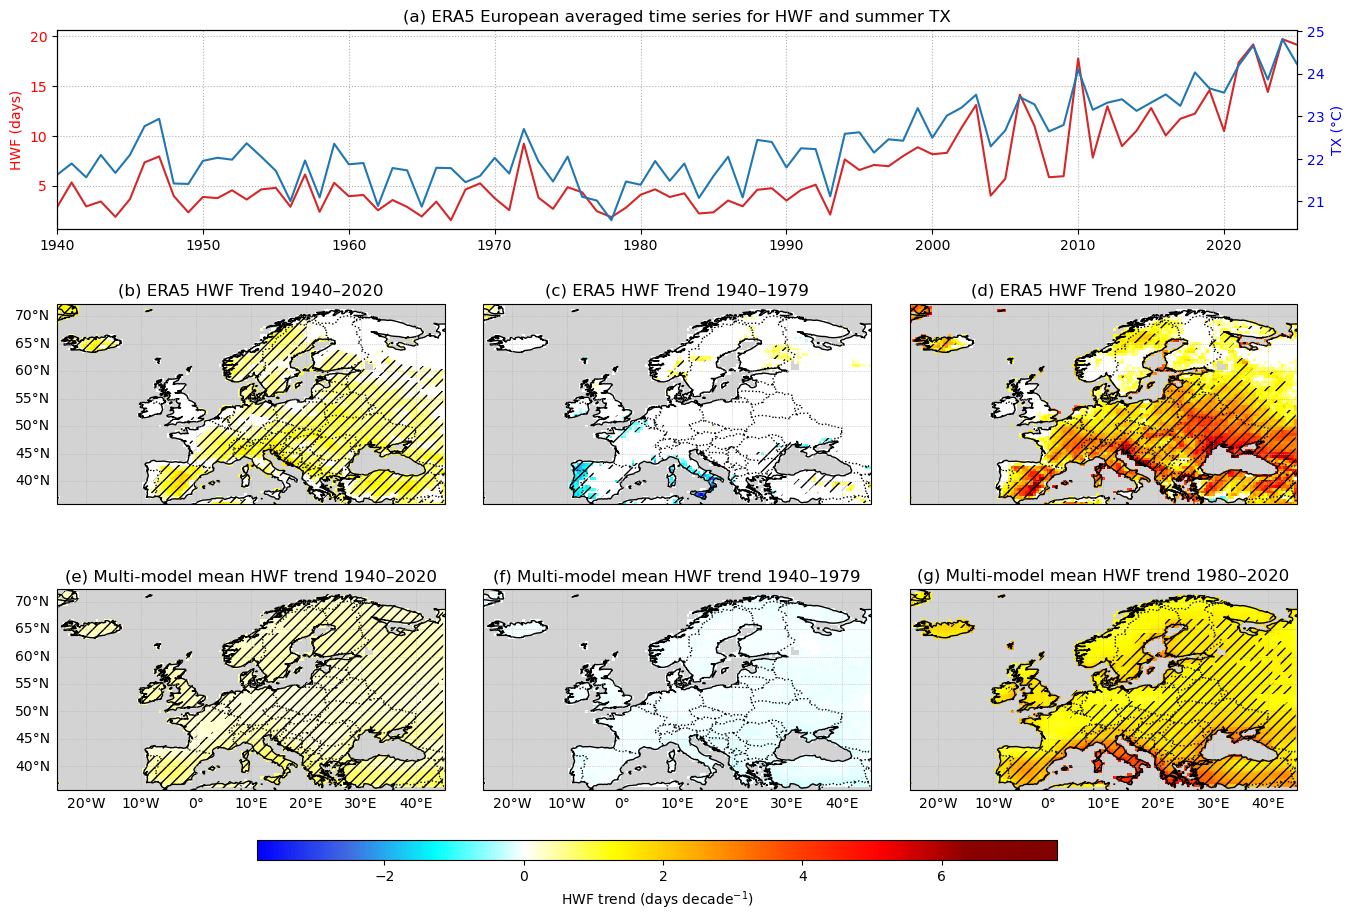

In [5]:

# --- same variable names as before ---
var_whole = "days_slope_whole_period"
var_early = "days_slope_early_period"
var_late = "days_slope_late_period"

# Compute symmetric color scale around zero (keep using ERA5 range for comparability)
vmax = max(
    abs(ERA5_trends[var_whole]).max().item(),
    abs(ERA5_trends[var_early]).max().item(),
    abs(ERA5_trends[var_late]).max().item(),
)
vmin = min(
    (ERA5_trends[var_whole]).min().item(),
    (ERA5_trends[var_early]).min().item(),
    (ERA5_trends[var_late]).min().item(),
)
print(vmax)
print(vmin)
#vmin = -vmax  # symmetric scale

x,y,c = zip(*np.random.rand(30,3)*4-2)

cvals  = [vmin, 0, vmax/3, 2*vmax/3, vmax]
colors = ["blue","white","orange", "red", "darkred"]

cvals  = [vmin, 2*vmin/3, vmin/3, 0, vmax/6, 2* vmax/6, 3* vmax/6, 4* vmax/6, 5*vmax/6, vmax]
colors = ["blue", "royalblue","cyan", "white","yellow", "orange", "orangered", "red", "darkred", "maroon"]

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
colour_scale = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)
colour_scale.set_bad(color='lightgrey')

# Get significance masks (ERA5)
sig_whole = ERA5_trends[f"{var_whole.replace('slope', 'significance')}"]
sig_early = ERA5_trends[f"{var_early.replace('slope', 'significance')}"]
sig_late = ERA5_trends[f"{var_late.replace('slope', 'significance')}"]

# Get significance masks (MODELS)
model_sig_whole = model_trends[f"{var_whole.replace('slope', 'significance')}"] > 0.5
model_sig_early = model_trends[f"{var_early.replace('slope', 'significance')}"]> 0.5
model_sig_late = model_trends[f"{var_late.replace('slope', 'significance')}"]> 0.5

# --- Figure Layout: 3 rows now (time series, ERA5 maps, model maps) ---
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, height_ratios=[1.8, 2, 2], hspace=0.3, wspace=0.1)

# --- Time Series (top, spanning all 3 cols) ---
ax0 = fig.add_subplot(gs[0, :])
years = np.arange(1940, 1940 + len(ERA5_HWF_series))

ax0.plot(years, ERA5_HWF_series, label="ERA5 HWF (days)", color="tab:red")
ax0.set_ylabel("HWF (days)", color="red")
ax0.tick_params(axis="y", labelcolor="red")
ax0.set_title("(a) ERA5 European averaged time series for HWF and summer TX")
ax0.grid(True, linestyle=":")
ax0.set_xlim(1940, years[-1])

ax1 = ax0.twinx()
ax1.plot(years, ERA5_TX_series - 273.15, label="ERA5 TX (°C)", color="tab:blue")
ax1.set_ylabel("TX (°C)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# --- ERA5 Maps (middle row) ---
# Whole period
ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
im0 = ax2.pcolormesh(
    ERA5_trends.lon, ERA5_trends.lat, ERA5_trends[var_whole].squeeze(),
    cmap=colour_scale, vmin=vmin, vmax=vmax, shading="auto"
)
ax2.coastlines()
ax2.add_feature(cfeature.BORDERS, linestyle=":")
ax2.set_title("(b) ERA5 HWF Trend 1940–2020")
ax2.contourf(ERA5_trends.lon, ERA5_trends.lat, sig_whole.squeeze(),
             levels=[0.5, 1.5], colors="none", hatches=["/ / /"])
gl = ax2.gridlines(draw_labels=False, linestyle=":", linewidth=0.5)
gl.left_labels = True

# Early
ax3 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
im1 = ax3.pcolormesh(
    ERA5_trends.lon, ERA5_trends.lat, ERA5_trends[var_early].squeeze(),
    cmap=colour_scale, vmin=vmin, vmax=vmax, shading="auto"
)
ax3.coastlines()
ax3.add_feature(cfeature.BORDERS, linestyle=":")
ax3.set_title("(c) ERA5 HWF Trend 1940–1979")
ax3.contourf(ERA5_trends.lon, ERA5_trends.lat, sig_early.squeeze(),
             levels=[0.5, 1.5], colors="none", hatches=["/ / /"])
gl = ax3.gridlines(draw_labels=False, linestyle=":", linewidth=0.5)

# Late
ax4 = fig.add_subplot(gs[1, 2], projection=ccrs.PlateCarree())
im2 = ax4.pcolormesh(
    ERA5_trends.lon, ERA5_trends.lat, ERA5_trends[var_late].squeeze(),
    cmap=colour_scale, vmin=vmin, vmax=vmax, shading="auto"
)
ax4.coastlines()
ax4.add_feature(cfeature.BORDERS, linestyle=":")
ax4.set_title("(d) ERA5 HWF Trend 1980–2020")
ax4.contourf(ERA5_trends.lon, ERA5_trends.lat, sig_late.squeeze(),
             levels=[0.5, 1.5], colors="none", hatches=["/ / /"])
gl = ax4.gridlines(draw_labels=False, linestyle=":", linewidth=0.5)

# --- Model Mean Maps (bottom row) ---
axm0 = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree())
m_im0 = axm0.pcolormesh(
    model_trends.lon, model_trends.lat, model_trends[var_whole].squeeze(),
    cmap=colour_scale, vmin=vmin, vmax=vmax, shading="auto"
)
axm0.coastlines()
axm0.add_feature(cfeature.BORDERS, linestyle=":")
axm0.set_title("(e) Multi-model mean HWF trend 1940–2020")
axm0.contourf(model_trends.lon, model_trends.lat, model_sig_whole.squeeze(),
             levels=[0.5, 1.5], colors="none", hatches=["/ / /"])
gl = axm0.gridlines(draw_labels=True, linestyle=":", linewidth=0.5)
gl.top_labels = False
gl.right_labels = False

axm1 = fig.add_subplot(gs[2, 1], projection=ccrs.PlateCarree())
m_im1 = axm1.pcolormesh(
    model_trends.lon, model_trends.lat, model_trends[var_early].squeeze(),
    cmap=colour_scale, vmin=vmin, vmax=vmax, shading="auto"
)
axm1.coastlines()
axm1.add_feature(cfeature.BORDERS, linestyle=":")
axm1.set_title("(f) Multi-model mean HWF trend 1940–1979")
axm1.contourf(model_trends.lon, model_trends.lat, model_sig_early.squeeze(),
             levels=[0.5, 1.5], colors="none", hatches=["/ / /"])
gl = axm1.gridlines(draw_labels=False, linestyle=":", linewidth=0.5)
gl.bottom_labels = True

axm2 = fig.add_subplot(gs[2, 2], projection=ccrs.PlateCarree())
m_im2 = axm2.pcolormesh(
    model_trends.lon, model_trends.lat, model_trends[var_late].squeeze(),
    cmap=colour_scale, vmin=vmin, vmax=vmax, shading="auto"
)
axm2.coastlines()
axm2.add_feature(cfeature.BORDERS, linestyle=":")
axm2.set_title("(g) Multi-model mean HWF trend 1980–2020")
axm2.contourf(model_trends.lon, model_trends.lat, model_sig_late.squeeze(),
             levels=[0.5, 1.5], colors="none", hatches=["/ / /"])
gl = axm2.gridlines(draw_labels=False, linestyle=":", linewidth=0.5)
gl.bottom_labels = True

# --- Shared colorbar below the bottom row of maps ---
# position tuned so it sits under both map rows
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.02])  # [left, bottom, width, height] in figure coords
fig.colorbar(m_im2, cax=cbar_ax, orientation="horizontal",
             label="HWF trend (days decade$^{-1}$)")

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig('plot1_11.11.25.png', bbox_inches='tight', pad_inches=0.2, dpi=300)
plt.show()

/tmp/ipykernel_4785/714515784.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout() #rect=[0, 0.03, 1, 0.97])


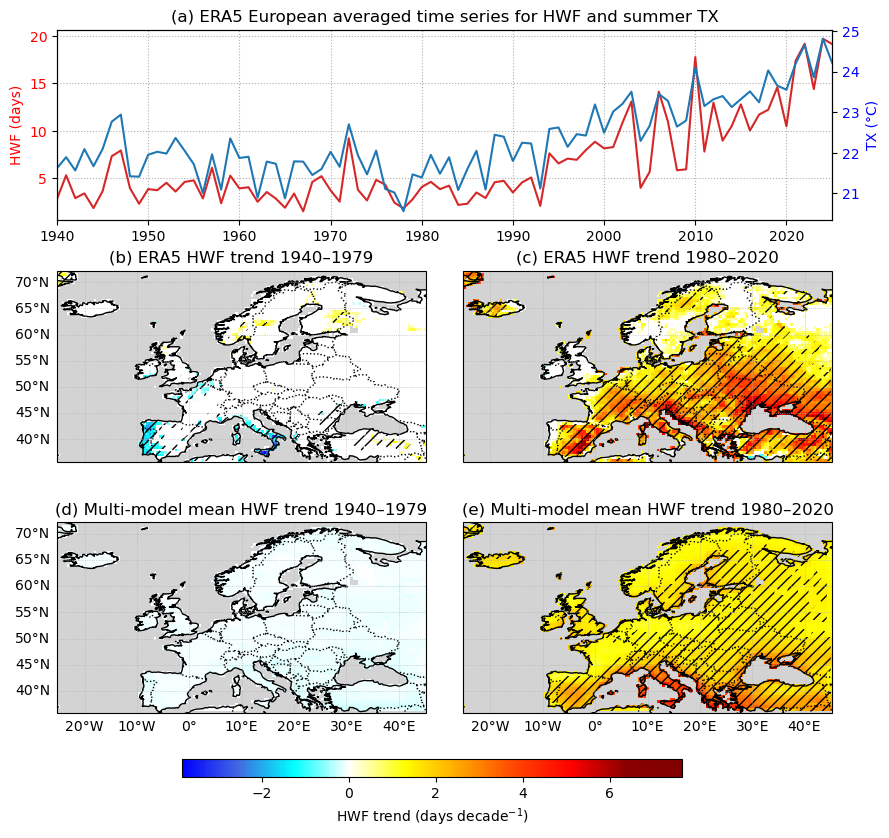

In [6]:
scales = ['CMRmap_r', 'Dark2_r', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'afmhot_r', 'cmo.matter', 'cmo.phase_i_r', 'cmo.thermal', 'coolwarm', 'gnuplot','inferno', 'jet_r']
colour_scale = "CMRmap_r" #"RdBu_r"

# --- same variable names as before ---
var_whole = "days_slope_whole_period"
var_early = "days_slope_early_period"
var_late = "days_slope_late_period"

# Compute symmetric color scale around zero (keep using ERA5 range for comparability)
vmax = max(
    abs(ERA5_trends[var_whole]).max().item(),
    abs(ERA5_trends[var_early]).max().item(),
    abs(ERA5_trends[var_late]).max().item(),
)

vmin = min(
    (ERA5_trends[var_whole]).min().item(),
    (ERA5_trends[var_early]).min().item(),
    (ERA5_trends[var_late]).min().item(),
)
#print(vmax)
#print(vmin)

#vmin = model_trends[var_early].min().item()
#vmax = model_trends[var_early].max().item()

x,y,c = zip(*np.random.rand(30,3)*4-2)

cvals  = [vmin, vmin/2, 0, vmax/3, 2*vmax/3, vmax]
colors = ["blue","cyan", "white","orange", "red", "darkred"]

cvals  = [vmin, 2*vmin/3, vmin/3, 0, vmax/6, 2* vmax/6, 3* vmax/6, 4* vmax/6, 5*vmax/6, vmax]
colors = ["blue", "royalblue","cyan", "white","yellow", "orange", "orangered", "red", "darkred", "maroon"]

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
colour_scale = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)
colour_scale.set_bad(color='lightgrey')

# Get significance masks (ERA5)
sig_whole = ERA5_trends[f"{var_whole.replace('slope', 'significance')}"]
sig_early = ERA5_trends[f"{var_early.replace('slope', 'significance')}"]
sig_late = ERA5_trends[f"{var_late.replace('slope', 'significance')}"]

# Get significance masks (MODELS)
model_sig_whole = model_trends[f"{var_whole.replace('slope', 'significance')}"] > 0.5
model_sig_early = model_trends[f"{var_early.replace('slope', 'significance')}"]> 0.5
model_sig_late = model_trends[f"{var_late.replace('slope', 'significance')}"]> 0.5

# --- Figure Layout: 3 rows now (time series, ERA5 maps, model maps) ---
fig = plt.figure(figsize=(10, 9))
gs = fig.add_gridspec(3, 2, height_ratios=[1.8, 2, 2], hspace=0.2, wspace=0.1)

# --- Time Series (top, spanning all 3 cols) ---
ax0 = fig.add_subplot(gs[0, :])
years = np.arange(1940, 1940 + len(ERA5_HWF_series))

ax0.plot(years, ERA5_HWF_series, label="ERA5 HWF (days)", color="tab:red")
ax0.set_ylabel("HWF (days)", color="red")
ax0.tick_params(axis="y", labelcolor="red")
ax0.set_title("(a) ERA5 European averaged time series for HWF and summer TX")
ax0.grid(True, linestyle=":")
ax0.set_xlim(1940, years[-1])

ax1 = ax0.twinx()
ax1.plot(years, ERA5_TX_series - 273.15, label="ERA5 TX (°C)", color="tab:blue")
ax1.set_ylabel("TX (°C)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# --- ERA5 Maps (middle row) ---

# Early
ax3 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
im1 = ax3.pcolormesh(
    ERA5_trends.lon, ERA5_trends.lat, ERA5_trends[var_early].squeeze(),
    cmap=colour_scale, vmin=vmin, vmax=vmax, shading="auto"
)
ax3.coastlines()
ax3.add_feature(cfeature.BORDERS, linestyle=":")
ax3.set_title("(b) ERA5 HWF trend 1940–1979")
ax3.contourf(ERA5_trends.lon, ERA5_trends.lat, sig_early.squeeze(),
             levels=[0.5, 1.5], colors="none", hatches=["/ / /"])
gl = ax3.gridlines(draw_labels=False, linestyle=":", linewidth=0.5)
gl.left_labels = True

# Late
ax4 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
im2 = ax4.pcolormesh(
    ERA5_trends.lon, ERA5_trends.lat, ERA5_trends[var_late].squeeze(),
    cmap=colour_scale, vmin=vmin, vmax=vmax, shading="auto"
)
ax4.coastlines()
ax4.add_feature(cfeature.BORDERS, linestyle=":")
ax4.set_title("(c) ERA5 HWF trend 1980–2020")
ax4.contourf(ERA5_trends.lon, ERA5_trends.lat, sig_late.squeeze(),
             levels=[0.5, 1.5], colors="none", hatches=["/ / /"])
gl = ax4.gridlines(draw_labels=False, linestyle=":", linewidth=0.5)

# --- Model Mean Maps (bottom row) ---
axm1 = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree())
m_im1 = axm1.pcolormesh(
    model_trends.lon, model_trends.lat, model_trends[var_early].squeeze(),
    cmap=colour_scale, vmin=vmin, vmax=vmax, shading="auto"
)
axm1.coastlines()
axm1.add_feature(cfeature.BORDERS, linestyle=":")
axm1.set_title("(d) Multi-model mean HWF trend 1940–1979")
axm1.contourf(model_trends.lon, model_trends.lat, model_sig_early.squeeze(),
             levels=[0.5, 1.5], colors="none", hatches=["/ / /"])
gl = axm1.gridlines(draw_labels=False, linestyle=":", linewidth=0.5)
gl.bottom_labels = True
gl.left_labels = True

axm2 = fig.add_subplot(gs[2, 1], projection=ccrs.PlateCarree())
m_im2 = axm2.pcolormesh(
    model_trends.lon, model_trends.lat, model_trends[var_late].squeeze(),
    cmap=colour_scale, vmin=vmin, vmax=vmax, shading="auto"
)
axm2.coastlines()
axm2.add_feature(cfeature.BORDERS, linestyle=":")
axm2.set_title("(e) Multi-model mean HWF trend 1980–2020")
axm2.contourf(model_trends.lon, model_trends.lat, model_sig_late.squeeze(),
             levels=[0.5, 1.5], colors="none", hatches=["/ / /"])
gl = axm2.gridlines(draw_labels=False, linestyle=":", linewidth=0.5)
gl.bottom_labels = True

# --- Shared colorbar below the bottom row of maps ---
# position tuned so it sits under both map rows
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.02])  # [left, bottom, width, height] in figure coords
fig.colorbar(m_im2, cax=cbar_ax, orientation="horizontal",
             label="HWF trend (days decade$^{-1}$)")

plt.tight_layout() #rect=[0, 0.03, 1, 0.97])
plt.savefig('plot1_19.11.25_reduced.png', bbox_inches='tight', pad_inches=0.2, dpi=300)
plt.show()